<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S74_drone_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
%pip install -q -U gtbook


Note: you may need to restart the kernel to use updated packages.


In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook.drone import axes
from gtbook.display import show
from gtbook.html import HTML
import gtsam.utils.plot as gtsam_plot


# Visual SLAM

> When we do SLAM with cameras, we call it visual SLAM.

<img src="Figures7/S74-Autonomous_camera_drone-04.jpg" alt="Splash image with strange drone presumably thinking about maps" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

Visual SLAM *almost* the same problem as the "SLAM with Landmarks" problem from Section 6.4, but we will now use 3D poses and 3D points, and we will use the inertial measurements from the IMU to inform us about the movement of the platform. This is a typical pipeline on drones, phones, etc., everything with an IMU.

## Integrating the IMU

We start off by encoding the information provided by the inertial measurement unit (IMU) in a factor graph.

As an example in code, below we define a scenario with forward velocity 2m/s, while pitching up
with angular velocity 30 degree/sec (negative in FLU). We set up a simulation using a built-in GTSAM class called the `ScenarioRunner`. To use this class, we need to define four things:

- a scenario: below we use a "constant twist" scenario, which is very much like the example in Section 7.2, a constant angular and linear velocity specified in the body frame
- noise parameters for the gyroscope and accelerometer
- the sample frequency, which we set at 10Hz
- bias parameters, to simulate how a bias actually corrupts the IMU measurements

We then create a `runner` with these:

In [26]:
# Set up the scenario with a constant velocity model, both angular (W) and linear (V)
wb = np.array([0, -np.radians(30), 0])
vb = np.array([2, 0, 0])
scenario = gtsam.ConstantTwistScenario(wb, vb)

# Create noise parameters
noise_parameters = gtsam.PreintegrationParams.MakeSharedU(9.8)
kGyroSigma = np.radians(0.5) / 60  # 0.5 degree ARW
kAccelSigma = 0.1 / 60  # 10 cm VRW
I3 = np.identity(3, float)
noise_parameters.setGyroscopeCovariance(kGyroSigma**2 * I3)
noise_parameters.setAccelerometerCovariance(kAccelSigma**2 * I3)
noise_parameters.setIntegrationCovariance(0.0000001**2 * I3) # ignore this for now

# Set the sample time
dt = 0.1 # 10 Hz

# Create bias parameters
accBias = np.array([0, 0.1, 0]) # bias in accelerometer
gyroBias = np.array([0, 0, 0]) # bias in gyroscope
bias = gtsam.imuBias.ConstantBias(accBias, gyroBias)

# Instantiate IMU simulation class as `runner`
runner = gtsam.ScenarioRunner(scenario, noise_parameters, dt, bias)


Our approach will be to use the `runner` class to generate noisy measurements, and then use GTSAM to optimize for the optimal trajectory given those measurements.

With the `scenario` class, we can create some (good) initial values by calling the `scenario.navState` at $t=0$ as well as every 5 steps, which is twice per second, given our sampling time $dt=0.1$:

In [27]:
# Define key naming scheme for GTSAM
X = gtsam.symbol_shorthand.X # for poses
V = gtsam.symbol_shorthand.V # for velocities
B0 = gtsam.symbol('b', 0) # for bias

# Create values and add initial state
values = gtsam.Values()
state = scenario.navState(0)
print(f"Adding initial state with position {np.round(state.pose().translation(),1)}")
values.insert(X(0), state.pose())
values.insert(V(0), state.velocity())

i, T = 0, 3.5 # run scenario at 10Hz for 3.5 seconds, adding state every 5th iteration
for j, t in enumerate(np.arange(0, T, dt)):
    if j>0 and j % 5 == 0:
        # create IMU factor
        i += 1
        state = scenario.navState(t)
        print(f"Adding navState {i} at t={t} with position {np.round(state.pose().translation(),1)}")
        values.insert(X(i), state.pose().retract(np.random.normal(scale=0.1, size=(6,))))
        values.insert(V(i), state.velocity() + np.random.normal(scale=0.1, size=(3,)))

# Add bias, as we will need it below
values.insert(B0, bias)


Adding initial state with position [0. 0. 0.]
Adding navState 1 at t=0.5 with position [1.  0.  0.1]
Adding navState 2 at t=1.0 with position [1.9 0.  0.5]
Adding navState 3 at t=1.5 with position [2.7 0.  1.1]
Adding navState 4 at t=2.0 with position [3.3 0.  1.9]
Adding navState 5 at t=2.5 with position [3.7 0.  2.8]
Adding navState 6 at t=3.0 with position [3.8 0.  3.8]


Now we will create the most complicated factor graph of the entire book, as it involves a factor that is connected to no less than five unknowns at every step. GTSAM contains a powerful, state of the art factor called the `ImuFactor` that allows us to accumulate IMU measurements and periodically add the resulting relative pose information to the graph. 

The accumulation of (high-rate) IMU measurements is done in a class called `PreintegratedImuMeasurements`, abbreviated "PIM", which is done at 10Hz.
Every 5 steps we add an `ImuFactor` that is connected to two successive poses with keys `X(i)` and `X(i+1)` and their corresponding velocities with keys `V(i)` and `V(i+1)`, as well as the (single) bias unknown with key `B(0)`.

In [28]:
# Create graph
imu_graph = gtsam.NonlinearFactorGraph()
Iso = gtsam.noiseModel.Isotropic
state = scenario.navState(0)
imu_graph.addPriorPose3(X(0), state.pose(), Iso.Sigma(6, 0.1))
imu_graph.addPriorVector(V(0), state.velocity(), Iso.Sigma(3, 0.1))
imu_graph.addPriorConstantBias(B0, bias, Iso.Sigma(6, 0.1))

i, T = 0, 3.5 # run scenario at 10Hz for 3.5 seconds, adding state every 5th iteration
pim = gtsam.PreintegratedImuMeasurements(noise_parameters, bias)
for j, t in enumerate(np.arange(0, T, dt)):
    measuredOmega = runner.measuredAngularVelocity(t)
    measuredAcc = runner.measuredSpecificForce(t)
    pim.integrateMeasurement(measuredAcc, measuredOmega, dt)
    if j>0 and j % 5 == 0:
        # create IMU factor
        factor = gtsam.ImuFactor(X(i), V(i), X(i + 1), V(i + 1), B0, pim)
        imu_graph.push_back(factor)
        i += 1
        pim.resetIntegration()


The graph displayed below shows (a bit messily) that the IMUFactors tie together the `Pose3` states $x_k$, the velocities $v_k$ and the unknown IMU biases $b_0$.

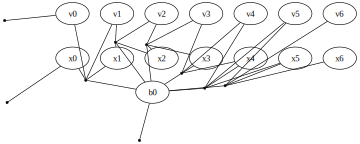

In [29]:
position_hints = {'u': 2, 'x': 1, 'z': 0}
position_hints.update({'v':2})
show(imu_graph, gtsam.Values(), hints=position_hints)


We can optimize even *without* any external measurements, but unless you pay for a very expensive IMU, your estimate will drift very rapidly.

In [30]:
print(f"initial error: {imu_graph.error(values)}")
try:
    lm = gtsam.LevenbergMarquardtOptimizer(imu_graph, values)
    imu_result = lm.optimize()
except RuntimeError:
    print("LM Optimization failed")
print(f"final error: {imu_graph.error(imu_result)}")


initial error: 22986061.569660265
final error: 1.551101729464746e-23


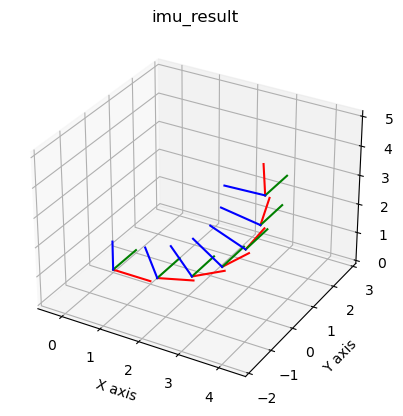

In [31]:
i = 0
while imu_result.exists(X(i)):
    gtsam_plot.plot_pose3(1, imu_result.atPose3(X(i)), 1)
    i += 1
plt.title("imu_result")
gtsam.utils.plot.set_axes_equal(1)


### Incorporating Visual Measurements

TBD, but see [this example](https://gtbook.github.io/gtsam-examples/StereoVOExample_large.html).

## Structure from Motion

![Balbianello](https://github.com/gtbook/robotics/blob/main/Figures7/Balbianello.jpg?raw=1 "Balbianello")

Structure from Motion, or SfM, is the problem of computing the 3D structure of a scene from multiple images, either taken from different cameras, or taken at different times as the camera moves in the environment. In the figure above we show one such image sequence, five images of the "Balbianello" villa in Italy, situated on lake Como.

SfM is almost the same problem as Visual SLAM, but typically there is no odometry information to relate
different camear views. The resulting optimization problem is sometimes called **Bundle Adjustment**. 
The most difficult problems associated with SfM are feature detection, data association, and initializing the optimization.

Below we load the Balbianello data from a file and create a factor graph, as well as an initial estimate.

In [32]:
filename = gtsam.findExampleDataFile("Balbianello.out")
sfm_data = gtsam.SfmData.FromBundlerFile(filename)
model = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v
graph = sfm_data.sfmFactorGraph(model)
initial = gtsam.initialCamerasAndPointsEstimate(sfm_data)
print(f"initial error: {graph.error(initial)}")


initial error: 126.92834251964683


We then optimize, as usual, now performing structure from motion: we optimize for both the unknown camera poses (calibration is assumed known here) and the unknown 3D points in the scene.


In [33]:
try:
    lm = gtsam.LevenbergMarquardtOptimizer(graph, initial)
    result = lm.optimize()
except RuntimeError:
    print("LM Optimization failed")
print(f"final error: {graph.error(result)}")


final error: 125.51738267205151


The result of SfM is a sparse point cloud and a set of well-determined camera poses, which can be "densified" using multi-view stereo techniques. This is out of scope of this book, however, and below we simply extract the 3D points and display them in 3D with `plotly`.

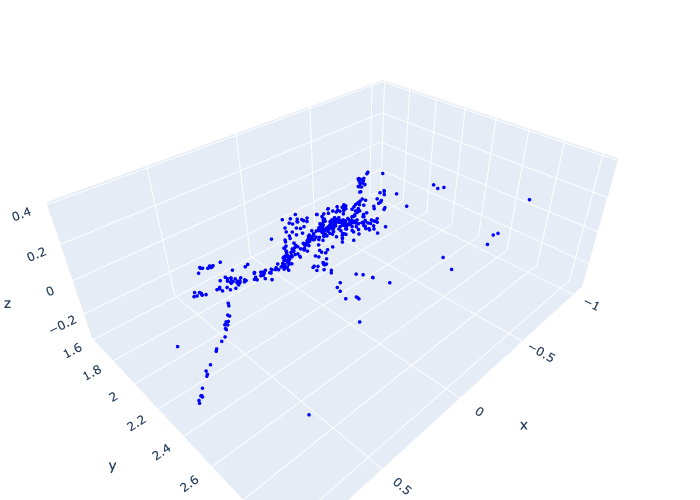

In [34]:
structure = gtsam.utilities.extractPoint3(result)
valid = structure[:,2] > -5.0
bRc = sfm_data.camera(0).pose().rotation()
wRc = gtsam.Rot3([1,0,0],[0,0,-1],[0,1,0]) # make camera point to world y
wRb = wRc.compose(bRc.inverse())
structure = (wRb.matrix() @ structure.T).T

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=structure[valid,0],y=structure[valid,1],z=structure[valid,2],
    mode="markers", marker=dict(size=2, color="blue"), showlegend= False))
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_yaxes(scaleanchor = "x", scaleratio = 1); fig.show()
